In [1]:
from collections import defaultdict
from dataclasses import dataclass
from functools import wraps
import random
from time import perf_counter_ns

import torch
from evo import Evo, generate
from stripedhyena.sample import sample

from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# run on GPU if available, otherwise panic
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available, just don't do it")

device = torch.device("cuda:0")

In [3]:
# download the model
evo_model = Evo("evo-1.5-8k-base")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# extract tokenizer and model
tokenizer = evo_model.tokenizer
model = evo_model.model.to(device)

# Functions – internal logits

In [5]:
def get_internal_acgt_probs(seq):
    """Get per-position nucleotide probabilities within a sequence. They go from position 1 to k+1."""
    tokens = torch.tensor(tokenizer.tokenize(seq), dtype=torch.int).unsqueeze(0).to(device)
    with torch.inference_mode():
        logits, _ = model(tokens)
    acgt_logits = logits[0,:,(65,67,71,84)]
    acgt_probs = torch.softmax(acgt_logits, dim=-1)
    return acgt_probs

In [6]:
def calc_simple_correctness(true_seq, y_scores):
    """Calculate prediction correctness assuming ungapped alignment."""
    arr = np.array(list(true_seq)).reshape(-1,1)
    real_arr = OneHotEncoder().fit_transform(arr).toarray()
    preds_moved = torch.cat((torch.tensor([[0.25, 0.25, 0.25, 0.25]], dtype=torch.float32), y_scores.to("cpu")[:-1]))
    pred_arr = preds_moved.to("cpu").to(torch.float32).numpy()
    correct = real_arr.argmax(axis=1) == pred_arr.argmax(axis=1)
    return sum(correct) / len(correct)

In [7]:
def calc_auroc(true_seq, y_scores):
    """Calculate AUROC from probabilities."""
    arr = np.array(list(true_seq)).reshape(-1,1)
    real_arr = OneHotEncoder().fit_transform(arr).toarray()
    preds_moved = torch.cat((torch.tensor([[0.25, 0.25, 0.25, 0.25]], dtype=torch.float32), y_scores.to("cpu")[:-1]))
    pred_arr = preds_moved.to("cpu").to(torch.float32).numpy()
    auroc = roc_auc_score(real_arr, pred_arr)
    return auroc

In [8]:
def calc_auprc(true_seq, y_scores):
    """Calculate AUPRC from probabilities."""
    arr = np.array(list(true_seq)).reshape(-1,1)
    real_arr = OneHotEncoder().fit_transform(arr).toarray()
    preds_moved = torch.cat((torch.tensor([[0.25, 0.25, 0.25, 0.25]], dtype=torch.float32), y_scores.to("cpu")[:-1]))
    pred_arr = preds_moved.to("cpu").to(torch.float32).numpy()
    auroc = average_precision_score(real_arr, pred_arr, average="weighted")
    return auroc

In [9]:
@dataclass
class SeqStats:
    biotype: str
    index: int
    mock: bool
    k: int
    correctness: float
    auroc: float
    auprc: float

In [10]:
def internal_stats_from_seq(seq):
    """Calculate AUROC and AUPRC from a sequence."""
    probs = get_internal_acgt_probs(seq)
    corr = calc_simple_correctness(seq, probs)
    auroc = calc_auroc(seq, probs)
    auprc = calc_auprc(seq, probs)
    return corr, auroc, auprc

In [11]:
def process_fasta_internal(path, *, biotype="unknown", index=0, k=1000):
    """Read the first sequence from a FASTA file, take k bp and calculate internal stats."""
    with open(path, "rt") as f:
        seqs = SeqIO.parse(f, "fasta")
        seq = next(seqs)
    corr, auroc, auprc = internal_stats_from_seq(str(seq.seq)[:k])
    return SeqStats(biotype=biotype, index=index, mock=False, k=k, correctness=corr, auroc=auroc, auprc=auprc)

In [12]:
def process_mock_internal(seq, *, biotype="unknown", index=0, k=1000):
    corr, auroc, auprc = internal_stats_from_seq(seq[:k])
    return SeqStats(biotype=biotype, index=index, mock=True, k=k, correctness=corr, auroc=auroc, auprc=auprc)

In [13]:
def generate_mock(original_seq, new_length, seed=None):
    """Generates a new DNA sequence with the same nucleotide frequencies as the original sequence."""
    # Convert to uppercase and count valid nucleotides
    counts = defaultdict(int)
    valid_nucleotides = {'A', 'T', 'C', 'G'}
    total = 0
    for char in original_seq.upper():
        if char in valid_nucleotides:
            counts[char] += 1
            total += 1
    
    if total == 0:
        raise ValueError("Original sequence contains no valid nucleotides (A, T, C, G).")
    
    # Prepare nucleotides and their corresponding weights (counts)
    nucleotides = []
    weights = []
    for nuc in ['A', 'T', 'C', 'G']:
        if counts[nuc] > 0:
            nucleotides.append(nuc)
            weights.append(counts[nuc])
    
    # Generate the new sequence using the calculated weights
    if seed is not None:
        random.seed(seed)
    new_sequence = ''.join(random.choices(nucleotides, weights=weights, k=new_length))
    return new_sequence

In [14]:
def mock_from_fasta(path, context_len, new_len, seed=None):
    with open(path, "rt") as f:
        seqs = SeqIO.parse(f, "fasta")
        seq = next(seqs)
    return generate_mock(seq[:context_len], new_len, seed=seed)

# Test some functions

In [15]:
with open("seqs/cds_1.fa", "rt") as f:
    seqs_cds = SeqIO.parse(f, "fasta")
    seq_cds = next(seqs_cds).seq

In [16]:
generate_mock(seq_cds, 100, seed=42)

'CATAGGGACAACAACCACGAGGTAGTAAGCGGCGCCGCGCGAATAAATCTTATGCCAGACGCCGGGAATTAGGTCCGCTTCTCGCAGCAAACGCACGCGG'

# Test on previous CDS sequence

In [17]:
# with open("seqs/cds_1.fa", 'r') as f:
#    seq_cds = ''.join(line.strip() for line in f)

In [18]:
# len(seq_cds)

In [19]:
# internal_stats_from_seq(seq_cds[:1000])

In [20]:
stats = []

In [21]:
stats_cds = process_fasta_internal("seqs/cds_1.fa", biotype="CDS", index=0)
stats.append(stats_cds)
print(stats_cds)

SeqStats(biotype='CDS', index=0, mock=False, k=1000, correctness=0.521, auroc=0.7387516561308416, auprc=0.5160719774325769)


# Test on intron and intergenic DNA

In [22]:
stats_intron = process_fasta_internal("seqs/intron_1.fa", biotype="intron", index=0)
stats.append(stats_intron)
print(stats_intron)

SeqStats(biotype='intron', index=0, mock=False, k=1000, correctness=0.414, auroc=0.6102379402731383, auprc=0.35071528501143623)


In [23]:
stats_intergenic = process_fasta_internal("seqs/intergenic_1.fa", biotype="intergenic", index=0)
stats.append(stats_intergenic)
print(stats_intergenic)

SeqStats(biotype='intergenic', index=0, mock=False, k=1000, correctness=0.607, auroc=0.8280435742284944, auprc=0.6878084556224981)


In [24]:
stats_cds_longer = process_fasta_internal("seqs/cds_1.fa", biotype="CDS", index=0, k=2000)
stats.append(stats_cds_longer)
print(stats_cds_longer)

SeqStats(biotype='CDS', index=0, mock=False, k=2000, correctness=0.511, auroc=0.7366895631570601, auprc=0.5119460362567128)


In [25]:
stats_intron_longer = process_fasta_internal("seqs/intron_1.fa", biotype="intron", index=0, k=2000)
stats.append(stats_intron_longer)
print(stats_intron_longer)

SeqStats(biotype='intron', index=0, mock=False, k=2000, correctness=0.4125, auroc=0.6326265903618302, auprc=0.38042887306327156)


In [26]:
stats_intergenic_longer = process_fasta_internal("seqs/intergenic_1.fa", biotype="intergenic", index=0, k=2000)
stats.append(stats_intergenic_longer)
print(stats_intergenic_longer)

SeqStats(biotype='intergenic', index=0, mock=False, k=2000, correctness=0.4715, auroc=0.7506465543266938, auprc=0.5411512545040694)


In [27]:
stats_intergenic_superlong = process_fasta_internal("seqs/intergenic_1.fa", biotype="intergenic", index=0, k=5000)
stats.append(stats_intergenic_superlong)
print(stats_intergenic_superlong)

SeqStats(biotype='intergenic', index=0, mock=False, k=5000, correctness=0.4304, auroc=0.7136169287300393, auprc=0.4905002083431107)


# Plots for internal stats

In [28]:
stats

[SeqStats(biotype='CDS', index=0, mock=False, k=1000, correctness=0.521, auroc=0.7387516561308416, auprc=0.5160719774325769),
 SeqStats(biotype='intron', index=0, mock=False, k=1000, correctness=0.414, auroc=0.6102379402731383, auprc=0.35071528501143623),
 SeqStats(biotype='intergenic', index=0, mock=False, k=1000, correctness=0.607, auroc=0.8280435742284944, auprc=0.6878084556224981),
 SeqStats(biotype='CDS', index=0, mock=False, k=2000, correctness=0.511, auroc=0.7366895631570601, auprc=0.5119460362567128),
 SeqStats(biotype='intron', index=0, mock=False, k=2000, correctness=0.4125, auroc=0.6326265903618302, auprc=0.38042887306327156),
 SeqStats(biotype='intergenic', index=0, mock=False, k=2000, correctness=0.4715, auroc=0.7506465543266938, auprc=0.5411512545040694),
 SeqStats(biotype='intergenic', index=0, mock=False, k=5000, correctness=0.4304, auroc=0.7136169287300393, auprc=0.4905002083431107)]

In [29]:
stats_df = pd.DataFrame(stats)

In [30]:
stats_df

,biotype,index,mock,k,correctness,auroc,auprc
0,CDS,0,False,1000,0.5210,0.738752,0.516072
1,intron,0,False,1000,0.4140,0.610238,0.350715
2,intergenic,0,False,1000,0.6070,0.828044,0.687808
3,CDS,0,False,2000,0.5110,0.736690,0.511946
4,intron,0,False,2000,0.4125,0.632627,0.380429
5,intergenic,0,False,2000,0.4715,0.750647,0.541151
6,intergenic,0,False,5000,0.4304,0.713617,0.490500


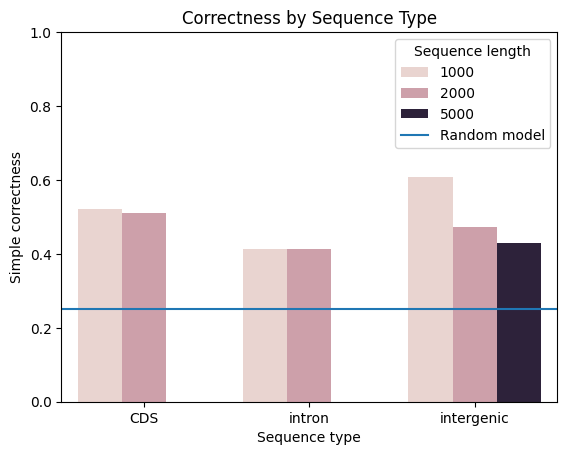

In [31]:
ax = sns.barplot(data=stats_df, x="biotype", y="correctness", hue="k")
ax.set_ylim(0,1)
ax.axhline(y=0.25, label="Random model")
ax.set(xlabel="Sequence type", ylabel="Simple correctness", title="Correctness by Sequence Type")
ax.legend().set_title("Sequence length")

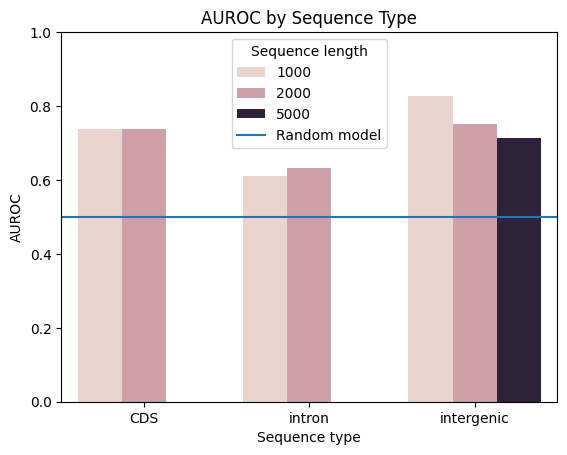

In [32]:
ax = sns.barplot(data=stats_df, x="biotype", y="auroc", hue="k")
ax.axhline(y=0.5, label="Random model")
ax.set_ylim(0,1)
ax.set(xlabel="Sequence type", ylabel="AUROC", title="AUROC by Sequence Type")
ax.legend().set_title("Sequence length")

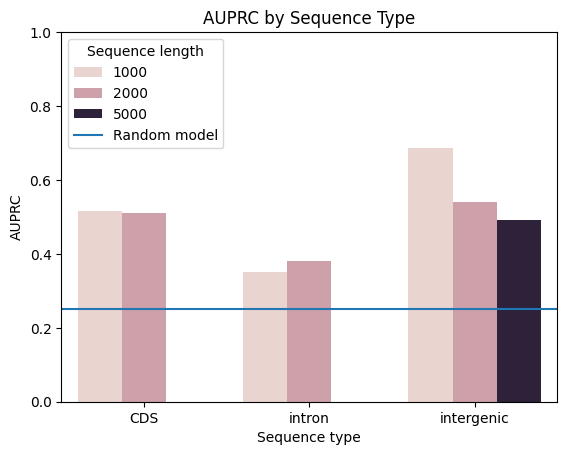

In [33]:
ax = sns.barplot(data=stats_df, x="biotype", y="auprc", hue="k")
ax.set_ylim(0,1)
ax.axhline(y=0.25, label="Random model")
ax.set(xlabel="Sequence type", ylabel="AUPRC", title="AUPRC by Sequence Type")
ax.legend().set_title("Sequence length")

# Mock sequences

In [34]:
mock_cds = mock_from_fasta("seqs/cds_1.fa", 1000, 1000, seed=42)
mock_cds

'CATAGGGACAACAACCACGAGGTAGTAAGCGGCGTCGCGCGAATAAATCTTATGCCAGATGCCGGGAATTAGGTCCGCTTCTCGCAGCAAACGCATGCGGAGGCTCACCGGTCAGGTCCAGCGCATAGGGTAGGACAGGACCTGCACGATGCCCAATCAAACAGGAAGAAGCCGGAACCCGGGACTGTACCTTGCGCAGGGGGACACATGTGCCGGCGATGCCGACCGAGAACGAAGTCCCCCGAGACGTTGACGGAATGGGTAGGCGCAGTCGAAACTCGACTCGGACTAGCTGCCAAGGCGCAATGGGGATAGGCCAGGGGGAGTGGGGTGAGGAGCTGAAATGGTCCGCGAGAGTACGTCCTCTGAGCGGGTAGTTGGTTCCTACGGGCTCATCCCCCACGGAACCTGGGAAAACGACCAGCACAGGACAGCATGCGGGCGGCGCGCGGCTTCGCCTATTTCAAGGACCCACGCGGGTATGGGCGCCAACATGCACACACCACACATATGTGGTAACGTCGCGGAAAAGCAGGACGAGGAATGGCGAGCAGGCAGGTCTCTGGAGCGGCGGTGCCCGTGGAGACCTAGAAGTGGTAGAGCGGCCGAAGTCCCCGTGTTAAACGAACGGCTAAAAACTGCGAGCGCCCAAGCGCACAACTGAGCGACCCGGTCCGGAACAAAACCTAGGCGGGCCGCCCGGAATGCTAGGGCCAACTTAGGCGGGTAGCCGACCCATTGGTGTGGCCTTGCCGCCCATGCGACGCGAGCAACCAGGCAGCGCTGGACTGCGGTGCGCGTTCGCACTCCCTAGCAGAGGGTCGGCACCGGCCCGCCACGTGCGGGTTGGGAACGGGCACGCGGAGTTACCGAAGCAGACTTAGGGACTCCCTGATCACCGTGCTCGGACCGTGCTCCGGCGCGCTCCGATGAACGCGGTGCGGTAGAGGGGGGTGACCGGCGGAAAGCGAAGGTCAGTCAGACGGGCGACACCGATCG

In [35]:
mock_stats = []

In [36]:
mock_cds_stats = process_mock_internal(mock_cds, biotype="CDS", index=0)
mock_stats.append(mock_cds_stats)
mock_cds_stats

SeqStats(biotype='CDS', index=0, mock=True, k=1000, correctness=0.313, auroc=0.497298246678084, auprc=0.2730725255561484)

In [37]:
mock_intron = mock_from_fasta("seqs/intron_1.fa", 1000, 1000, seed=42)
mock_intron_stats = process_mock_internal(mock_intron, biotype="intron")
mock_stats.append(mock_intron_stats)

In [38]:
mock_intergenic = mock_from_fasta("seqs/intergenic_1.fa", 1000, 1000, seed=42)
mock_intergenic_stats = process_mock_internal(mock_intergenic, biotype="intergenic")
mock_stats.append(mock_intergenic_stats)

In [39]:
mock_stats.append(stats_cds)
mock_stats.append(stats_intron)
mock_stats.append(stats_intergenic)

In [40]:
mock_df = pd.DataFrame(mock_stats)

In [41]:
mock_df

,biotype,index,mock,k,correctness,auroc,auprc
0,CDS,0,True,1000,0.313,0.497298,0.273073
1,intron,0,True,1000,0.314,0.494934,0.270048
2,intergenic,0,True,1000,0.420,0.488142,0.348797
3,CDS,0,False,1000,0.521,0.738752,0.516072
4,intron,0,False,1000,0.414,0.610238,0.350715
5,intergenic,0,False,1000,0.607,0.828044,0.687808


## Plots

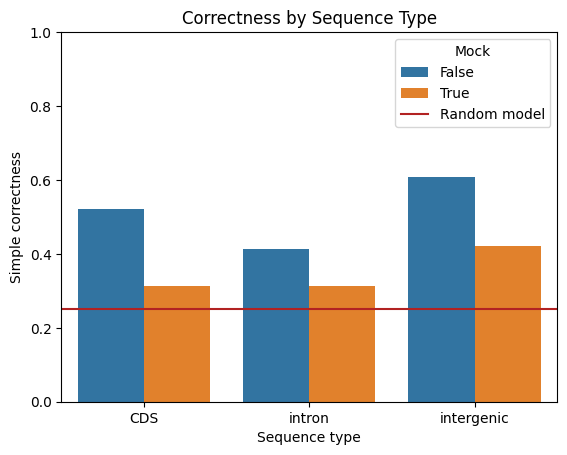

In [42]:
ax = sns.barplot(data=mock_df, x="biotype", y="correctness", hue="mock")
ax.set_ylim(0,1)
ax.axhline(y=0.25, color="firebrick", label="Random model")
ax.set(xlabel="Sequence type", ylabel="Simple correctness", title="Correctness by Sequence Type")
ax.legend().set_title("Mock")

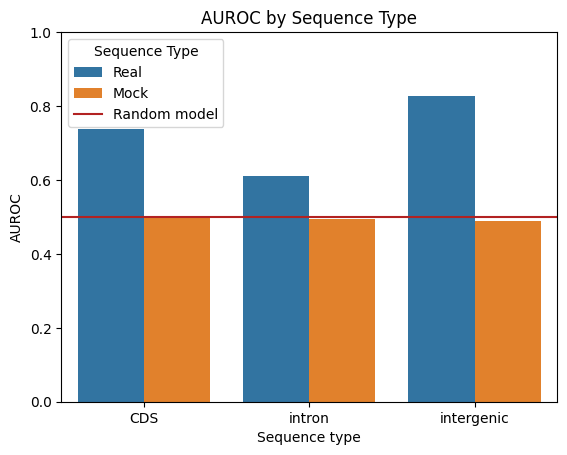

In [43]:
ax = sns.barplot(data=mock_df, x="biotype", y="auroc", hue="mock")
ax.set_ylim(0,1)
ax.axhline(y=0.5, color="firebrick", label="Random model")
ax.set(xlabel="Sequence type", ylabel="AUROC", title="AUROC by Sequence Type")
legend = ax.legend()
legend.set_title("Sequence Type")
legend.get_texts()[0].set_text("Real")
legend.get_texts()[1].set_text("Mock")

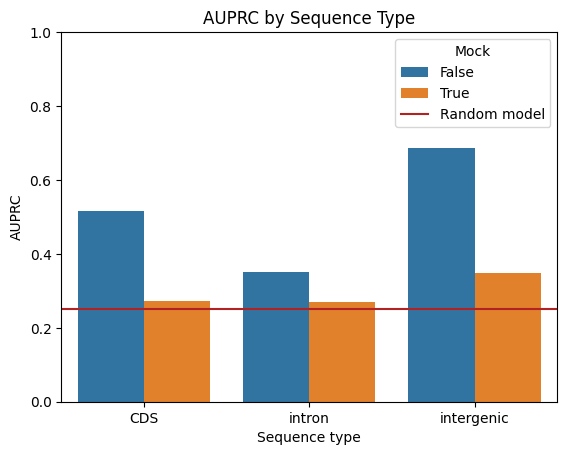

In [44]:
ax = sns.barplot(data=mock_df, x="biotype", y="auprc", hue="mock")
ax.set_ylim(0,1)
ax.axhline(y=0.25, color="firebrick", label="Random model")
ax.set(xlabel="Sequence type", ylabel="AUPRC", title="AUPRC by Sequence Type")
ax.legend().set_title("Mock")

# With lncRNA

In [45]:
stats_lnc = process_fasta_internal("seqs/lnc_1.fa", biotype="lncRNA", index=0)

In [46]:
mock_lnc = mock_from_fasta("seqs/lnc_1.fa", 1000, 1000, seed=42)
mock_lnc_stats = process_mock_internal(mock_lnc, biotype="lncRNA")

In [47]:
mock_stats_lnc = mock_stats + [stats_lnc, mock_lnc_stats]

In [48]:
len(mock_stats_lnc)

8

In [49]:
lnc_df = pd.DataFrame(mock_stats_lnc)

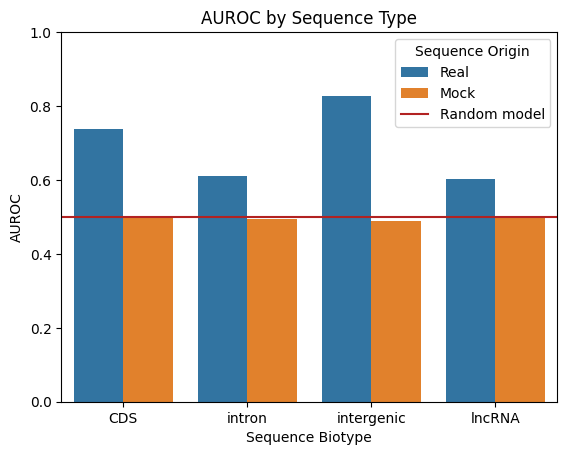

In [50]:
ax = sns.barplot(data=lnc_df, x="biotype", y="auroc", hue="mock")
ax.set_ylim(0,1)
ax.axhline(y=0.5, color="firebrick", label="Random model")
ax.set(xlabel="Sequence Biotype", ylabel="AUROC", title="AUROC by Sequence Type")
legend = ax.legend()
legend.set_title("Sequence Origin")
legend.get_texts()[0].set_text("Real")
legend.get_texts()[1].set_text("Mock")
plt.show()

In [51]:
with open("seqs/lnc_1.fa") as f:
    seqs = SeqIO.parse(f, "fasta")
    seq = next(seqs)

In [52]:
lnc_probs = get_internal_acgt_probs(str(seq.seq)[:1000])
lnc_probs.shape

torch.Size([1000, 4])

In [53]:
lnc_max_probs = lnc_probs.max(dim=1).values.to(torch.float32).to("cpu")
lnc_max_probs

tensor([0.2812, 0.3125, 0.2793, 0.3086, 0.3066, 0.3301, 0.2930, 0.3438, 0.3145,
        0.3203, 0.3262, 0.3242, 0.2871, 0.4043, 0.3066, 0.3301, 0.3125, 0.2949,
        0.2871, 0.3047, 0.2969, 0.3711, 0.3477, 0.4043, 0.3262, 0.3105, 0.3320,
        0.3867, 0.3770, 0.2969, 0.3730, 0.3809, 0.3477, 0.3145, 0.4570, 0.3105,
        0.3203, 0.3574, 0.2949, 0.2598, 0.2832, 0.3398, 0.3320, 0.4004, 0.3945,
        0.3066, 0.3398, 0.3105, 0.3398, 0.3926, 0.3359, 0.3027, 0.3711, 0.2949,
        0.4082, 0.4570, 0.4121, 0.4180, 0.3027, 0.3477, 0.4082, 0.3125, 0.2676,
        0.3262, 0.3086, 0.2812, 0.3535, 0.3047, 0.4648, 0.3535, 0.3008, 0.3848,
        0.3672, 0.4062, 0.3750, 0.4746, 0.3965, 0.3867, 0.3145, 0.3496, 0.4004,
        0.3301, 0.3262, 0.3359, 0.4023, 0.4082, 0.4512, 0.3340, 0.4043, 0.3320,
        0.2656, 0.3691, 0.3398, 0.3398, 0.4160, 0.5078, 0.2734, 0.4785, 0.4551,
        0.3438, 0.3223, 0.3027, 0.3418, 0.4746, 0.3730, 0.4277, 0.3262, 0.4707,
        0.3164, 0.2910, 0.3223, 0.3555, 

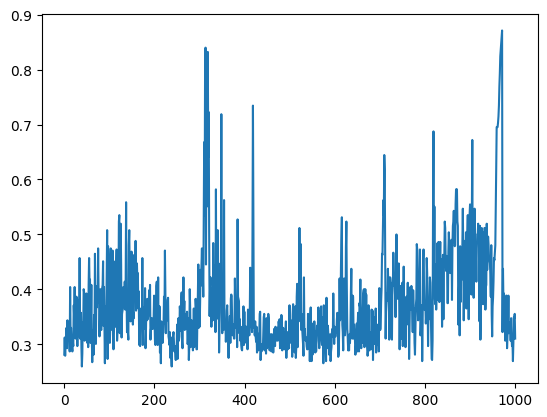

In [54]:
plt.plot(np.linspace(0,1000,1000), lnc_max_probs)

In [55]:
pos_idx = np.concatenate([np.tile([1,2,3], 333), np.array([1])])
pos_idx.shape

(1000,)

In [56]:
pos_df = pd.DataFrame({"conf": lnc_max_probs.numpy(), "pos": pos_idx})
pos_df

,conf,pos
0,0.281250,1
1,0.312500,2
2,0.279297,3
3,0.308594,1
4,0.306641,2
...,...,...
995,0.302734,3
996,0.349609,1
997,0.347656,2
998,0.355469,3


In [57]:
pos_conf = pos_df.groupby("pos").mean()
pos_conf

,conf
pos,
1,0.373415
2,0.375821
3,0.377458


In [58]:
pos_df["conf"].mean()

0.3755625

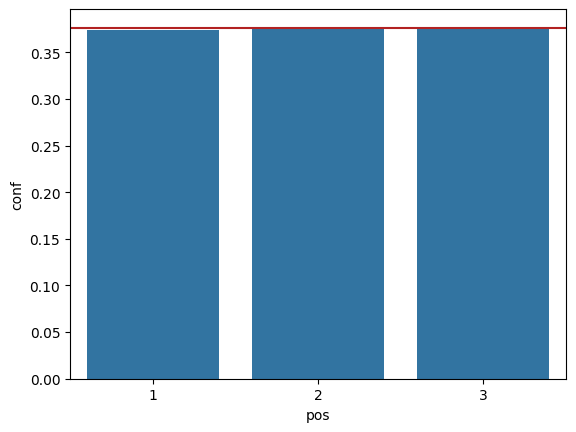

In [59]:
ax = sns.barplot(data = pos_conf, x = "pos", y = "conf")
ax.axhline(y=pos_df["conf"].mean(), color="firebrick")